In [30]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.structured import *
from fastai.column_data import *
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

np.set_printoptions(threshold=50, edgeitems=20)
pd.set_option('display.max_columns', None)
PATH='data/'

In [31]:
matches = pd.read_csv('data/results.csv', parse_dates=['date'])
matches.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False


In [32]:
matches.drop('neutral', axis=1, inplace=True) #this field is not accurate, try matches[(matches['home_team']!=matches['country']).values & (matches['neutral']==False).values]
matches.rename({'home_team':'team1',
                'away_team':'team2',
                'home_score':'team1_goal',
                'away_score':'team2_goal',
                'city':'venue_city',
                'country':'venue_country'}, axis=1, inplace=True)
matches = matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['venue_country'] = matches['venue_country'].replace({'French Polynesia': 'Tahiti', 'Serbia and Montenegro': 'Serbia'})
matches['team1_home'] = matches['team1'] == matches['venue_country']
matches.head()

,date,team1,team2,team1_goal,team2_goal,tournament,venue_city,venue_country,team1_home
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,True
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,True
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,True
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,True
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,True


In [33]:
rankings = pd.read_csv('data/fifa_ranking.csv', parse_dates=['rank_date'])
rankings.head(2)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08


In [34]:
rankings = rankings[rankings['total_points']>0]
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
# Ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()
rankings.head(2)

,rank_date,rank,country_full,country_abrv,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted,weighted_points
0,2011-08-24,181.0,Afghanistan,AFG,61.81,2.55,5.92,70.28
1,2011-08-25,181.0,Afghanistan,AFG,61.81,2.55,5.92,70.28


In [35]:
# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'team1'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'team2'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_team1', '_team2'))

add_datepart(matches, 'date', drop=False)
matches['rank_diff'] = matches['rank_team1'] - matches['rank_team2']
matches['rank_mean'] = (matches['rank_team1'] + matches['rank_team2'])/2
matches['point_diff'] = matches['weighted_points_team1'] - matches['weighted_points_team2']
matches['point_mean'] = (matches['weighted_points_team1'] + matches['weighted_points_team2'])/2
matches['goal_diff'] = (matches['team1_goal'] - matches['team2_goal']).astype(float)
matches.head(2)

,date,team1,team2,team1_goal,team2_goal,tournament,venue_city,venue_country,team1_home,rank_date_team1,rank_team1,country_full_team1,country_abrv_team1,cur_year_avg_weighted_team1,two_year_ago_weighted_team1,three_year_ago_weighted_team1,weighted_points_team1,rank_date_team2,rank_team2,country_full_team2,country_abrv_team2,cur_year_avg_weighted_team2,two_year_ago_weighted_team2,three_year_ago_weighted_team2,weighted_points_team2,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,rank_diff,rank_mean,point_diff,point_mean,goal_diff
0,2011-08-24,Guyana,India,2,1,Friendly,Providence,Guyana,True,2011-08-24,114.0,Guyana,GUY,183.89,18.28,23.68,225.85,2011-08-24,158.0,India,IND,53.20,7.65,20.69,81.54,2011,8,34,24,2,236,False,False,False,False,False,False,1314144000,-44.0,136.0,144.31,153.695,1.0
1,2011-08-24,Thailand,Singapore,0,0,Friendly,Bangkok,Thailand,True,2011-08-24,120.0,Thailand,THA,111.99,38.98,33.27,184.24,2011-08-24,129.0,Singapore,SIN,109.17,33.18,26.41,168.76,2011,8,34,24,2,236,False,False,False,False,False,False,1314144000,-9.0,124.5,15.48,176.500,0.0


In [36]:
world_cup = pd.read_csv('data/World Cup 2018 Dataset.csv')
world_cup.head(2)

,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN


In [37]:
world_cup = world_cup[['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')
world_cup.head(2)

,Group,First match against,Second match against,Third match against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt


In [42]:
cat_vars = ['team1', 'team2', 'tournament', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

contin_vars = ['team1_goal', 'rank_team1', 'cur_year_avg_weighted_team1', 'two_year_ago_weighted_team1', 'three_year_ago_weighted_team1', 'weighted_points_team1',
               'team2_goal', 'rank_team2', 'cur_year_avg_weighted_team2', 'two_year_ago_weighted_team2', 'three_year_ago_weighted_team2', 'weighted_points_team2',
               'rank_diff', 'rank_mean', 'point_diff', 'point_mean', 'Elapsed']

dep = 'goal_diff'

matches = matches[cat_vars+contin_vars+[dep]]

train, test = train_test_split(matches.copy(), test_size=0.2, random_state=42)

for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
apply_cats(test, train)
for v in contin_vars:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')
    
X_train, y_train, nas, mapper = proc_df(train, dep, do_scale=True)
X_test,  y_test,  nas, mapper = proc_df(test , dep, do_scale=True, mapper=mapper, na_dict=nas)

train_ratio = 0.75
train_size = int(len(train) * train_ratio)
val_idx = list(range(train_size, len(train)))
# val_idx = np.flatnonzero((df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

md = ColumnarModelData.from_data_frame(PATH, val_idx, X_train, y_train.astype(np.float32), cat_flds=cat_vars, bs=4, test_df=X_test)

In [43]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('team1', 194),
 ('team2', 195),
 ('tournament', 39),
 ('Year', 9),
 ('Month', 13),
 ('Week', 54),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 314),
 ('Is_month_end', 3),
 ('Is_month_start', 3),
 ('Is_quarter_end', 3),
 ('Is_quarter_start', 3),
 ('Is_year_end', 3),
 ('Is_year_start', 2)]

In [44]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(194, 50),
 (195, 50),
 (39, 20),
 (9, 5),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (314, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (2, 1)]

 35%|███▌      | 283/807 [00:02<00:03, 135.70it/s, loss=2.17] 


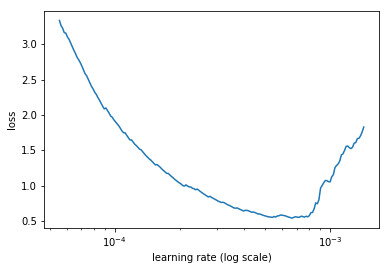

In [45]:
m = md.get_learner(emb_szs, len(X_train.columns)-len(cat_vars), 0.04, 1, [1000,500], [0.001,0.01], y_range=(np.min(y_train), np.max(y_train)))
m.lr_find()
m.sched.plot(100)

In [48]:
lr = 1e-4
m = md.get_learner(emb_szs, len(X_train.columns)-len(cat_vars), 0.04, 1, [1000,500], [0.001,0.01], y_range=(np.min(y_train), np.max(y_train)))

def mae(y_pred, targ):
    return mean_absolute_error(targ, y_pred)

In [49]:
m.fit(lr, 1, metrics=[mae], cycle_len=1)
m.save('val0')
pred_test=m.predict(is_test=True)

epoch      trn_loss   val_loss   mae                         
    0      2.363246   1.872182   1.032613  

